# Image manipulation

In this notebook you'll find code for some of the image manipulation techniques for the lecture.

First, some imports to set up our interpreter for image manipulation.

In [1]:
import cv2                             # Computer Vision
import numpy as np                     # Vector math
import ipywidgets as widgets           # For the interactive stuff
import os.path                         # File system
from sklearn.decomposition import PCA  # Dimensionality reduction
import matplotlib.pyplot as plt        # Plotting
%matplotlib inline

Let's generate an image with text.

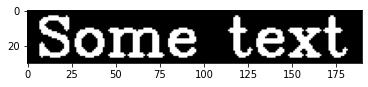

In [2]:
img = np.asarray(cv2.putText(np.zeros((30, 190)), "Some text", (5, 25), cv2.FONT_HERSHEY_COMPLEX,
                             1.0, (255, 255, 255), 2, cv2.LINE_AA)
                 , dtype=np.uint8)

plt.imshow(img, cmap='gray')
plt.show()

As you can see, this image is encoded as a 2d array. The image was generated as gray scale which simply removes the dimensions for the diffferent colour channels.

In [3]:
print(img.shape)
print(img)

(30, 190)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


A connected component is a patch of similarly coloured pixels. We can as OpenCV to find them for us.

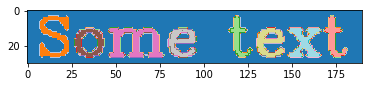

In [4]:
_, cc = cv2.connectedComponents(img, connectivity=4)
plt.imshow(cc, cmap='tab20')
plt.show()

Let's try some salt and papper noise. This is the type of noise you got from static interfering in some wireless transmission. Today, it is more applicable if we want to simulate ink deterioration. The following code is for the more classical area of application.

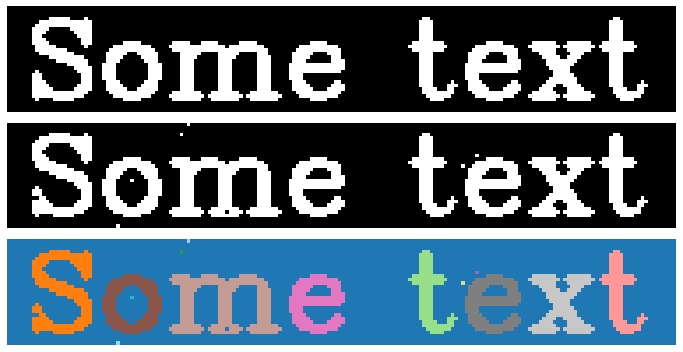

In [5]:
def salt_and_papper_noise(image, n_noise=10):
    img_sp = image.copy()
    for i in range(n_noise):
        a = np.random.randint(img_sp.shape[0])
        b = np.random.randint(img_sp.shape[1])
        if img_sp[a, b] == 0:
            img_sp[a, b] = 255
        else:
            img_sp[a, b] = 0
    return img_sp

img_sp = salt_and_papper_noise(img, 10)

plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(3, 1, 2)
plt.imshow(img_sp, cmap='gray')
plt.axis('off');
plt.subplot(3, 1, 3)
_, cc = cv2.connectedComponents(img_sp, connectivity=4)
plt.imshow(cc, cmap='tab20')
plt.axis('off');
plt.tight_layout()
plt.show()

As you can see, the noise is interpreted as more connected components.

Salt and pepper noise can, at least to some extent, be removed using a median filter. This type of filtering looks at a small neighbourhood of a pixel and replaces the pixel with the median value of this neighbourhood.

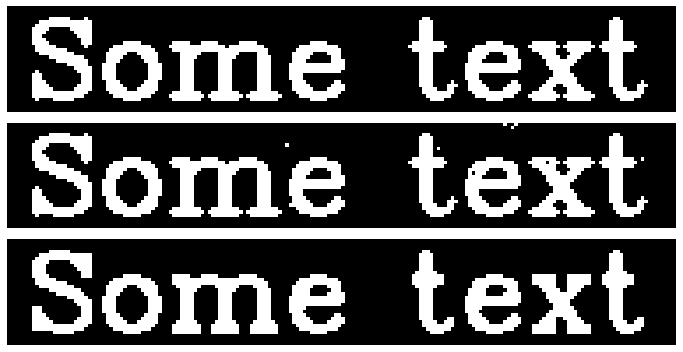

In [6]:
# Median filtering
img_sp = salt_and_papper_noise(img, 10)
img_median = cv2.medianBlur(img_sp, 3)

plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(3, 1, 2)
plt.imshow(img_sp, cmap='gray')
plt.axis('off');
plt.subplot(3, 1, 3)
plt.imshow(img_median, cmap='gray')
plt.axis('off');
plt.tight_layout()
plt.show()

## Gaussian noise

Another kind of common noise was Gaussian noise. This was the type of noise that made the image "grainy".

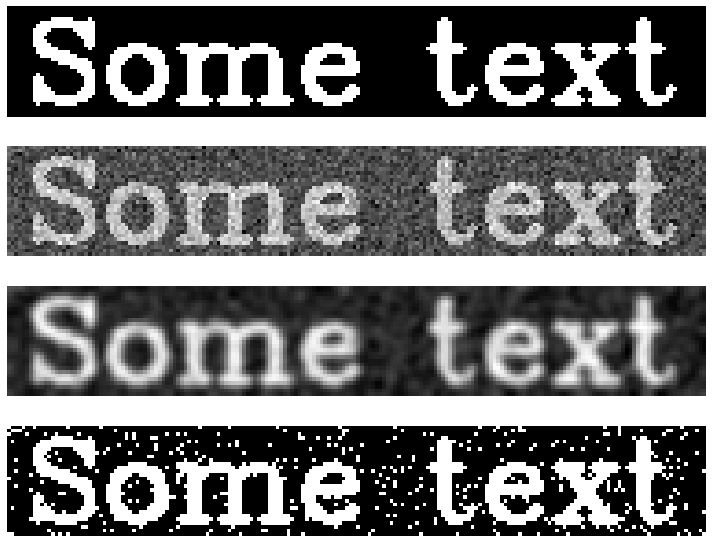

In [7]:
# When working with Gaussian noise, we need some space between the used colours and the data type limits.
img[img==0] = 100
img[img==255] = 200

# Add some Gaussian noise
sigma = 20
img_noise = img + np.random.normal(0, sigma, size=img.shape)

# Convert back to 8bit image
img_noise[img_noise<0] = 0
img_noise[img_noise>255] = 255
img_noise = np.asarray(img_noise, dtype=np.uint8)

# Blur to average out the noise
img_blur = cv2.GaussianBlur(img_noise, (5, 5), 0)

# Threshold the image to separate foreground and background
_, img_thresholded = cv2.threshold(img_noise, 127, 255, cv2.THRESH_BINARY)


plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.subplot(4, 1, 2)
plt.imshow(img_noise, cmap='gray')
plt.axis('off');
plt.subplot(4, 1, 3)
plt.imshow(img_blur, cmap='gray')
plt.axis('off');
plt.subplot(4, 1, 4)
plt.imshow(img_thresholded, cmap='gray')
plt.axis('off');
plt.tight_layout()
plt.show()

Now, let's try this while varying the noise intensity.

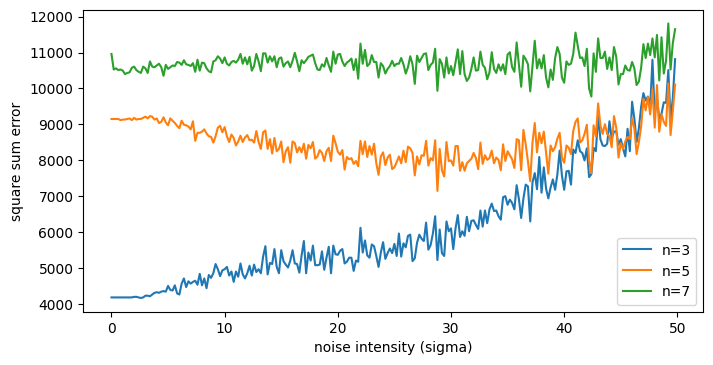

In [8]:
def distort(image, sigma):
    """Add Gaussian noise"""
    img_noise = image + np.random.normal(0, sigma, size=image.shape)
    img_noise[img_noise<0] = 0
    img_noise[img_noise>255] = 255
    return np.asarray(img_noise, dtype=np.uint8)

def blur(image, n):
    """Gaussian blur"""
    return cv2.GaussianBlur(image, (n, n), 0)

def binarize(image):
    """Separate foreground from background"""
    _, img_thresholded = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    img_thresholded[img_thresholded==0] = 100
    img_thresholded[img_thresholded==255] = 200
    return img_thresholded

sigmas = np.arange(0, 50, 0.2)
filter3 = list()
filter5 = list()
filter7 = list()
for sigma in sigmas:
    I = distort(img, sigma)
    filter3.append(np.sum((img - binarize(blur(I, 3)))**2))
    filter5.append(np.sum((img - binarize(blur(I, 5)))**2))
    filter7.append(np.sum((img - binarize(blur(I, 7)))**2))

plt.figure(figsize=(8, 4), dpi=100)
plt.plot(sigmas, filter3, label="n=3")
plt.plot(sigmas, filter5, label="n=5")
plt.plot(sigmas, filter7, label="n=7")
plt.legend(loc='lower right')
plt.ylabel("square sum error")
plt.xlabel("noise intensity (sigma)")
plt.show()

### Rendering text

Demo of how to render text in an image.

In [9]:
if not os.path.exists("Eisenhower.txt"):
  !wget https://raw.githubusercontent.com/fredrikwahlberg/5LN721/master/Eisenhower.txt

with open("Eisenhower.txt", 'r') as file:
    textlines = file.readlines()

fonts = [("FONT_HERSHEY_SIMPLEX", cv2.FONT_HERSHEY_SIMPLEX),
         ("FONT_HERSHEY_PLAIN", cv2.FONT_HERSHEY_PLAIN),
         ("FONT_HERSHEY_DUPLEX", cv2.FONT_HERSHEY_DUPLEX),
         ("FONT_HERSHEY_COMPLEX", cv2.FONT_HERSHEY_COMPLEX),
         ("FONT_HERSHEY_TRIPLEX", cv2.FONT_HERSHEY_TRIPLEX),
         ("FONT_HERSHEY_COMPLEX_SMALL", cv2.FONT_HERSHEY_COMPLEX_SMALL),
         ("FONT_HERSHEY_SCRIPT_SIMPLEX", cv2.FONT_HERSHEY_SCRIPT_SIMPLEX),
         ("FONT_HERSHEY_SCRIPT_COMPLEX", cv2.FONT_HERSHEY_SCRIPT_COMPLEX),
         ("FONT_ITALIC", cv2.FONT_ITALIC)]

--2020-11-11 12:39:22--  https://raw.githubusercontent.com/fredrikwahlberg/5LN721/master/Eisenhower.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1266 (1.2K) [text/plain]
Saving to: ‘Eisenhower.txt’

Eisenhower.txt      100%[===================>]   1.24K  --.-KB/s    in 0s      

2020-11-11 12:39:22 (64.9 MB/s) - ‘Eisenhower.txt’ saved [1266/1266]



In [10]:
textimage = None

def render_text(font):
  global textimage
  image = np.zeros((2000, 2000), dtype=np.uint8)
  # Render text lines
  y = 100
  for i, textline in enumerate(textlines):
    cv2.putText(image, textline.strip(), (100, y), fontFace=font, fontScale=1.0, color=(255, 255, 255), thickness=1, lineType=cv2.LINE_AA)
    res = cv2.getTextSize(textline, fontFace=font, fontScale=1.0, thickness=1)
    y += res[0][1]+res[1]
  # Trip the image
  while np.sum(image[:, :5]) == 0:
    image = image[:, 2:]
  while np.sum(image[:, -5:]) == 0:
    image = image[:, :-2]
  while np.sum(image[:5, :]) == 0:
    image = image[2:, :]
  while np.sum(image[-5:, :]) == 0:
    image = image[:-2, :]
  # Invert colours
  image = 255-image
  # Plot
  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='gray')
  plt.show()
  textimage = image

widgets.interact(render_text, font=fonts);

interactive(children=(Dropdown(description='font', options=(('FONT_HERSHEY_SIMPLEX', 0), ('FONT_HERSHEY_PLAIN'…

As shown briefly in the slides, we can detect the positions of the text lines quite easily by summing up the number of foreground pixels for each image row. I include it here as an example of traditional image analysis, for nostalgic reasons.

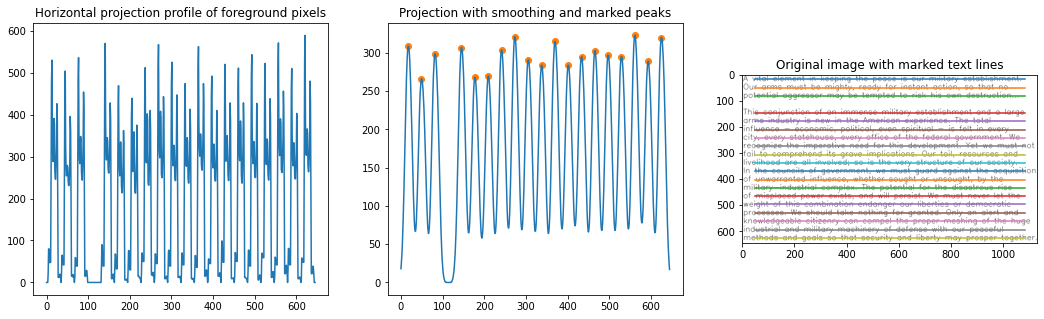

In [11]:
# Set up figure
fig = plt.figure(figsize=(18, 5))
ax = fig.subplots(1, 3)

# Subplot 1
projection = np.sum(textimage<255, axis=1)

ax[0].plot(projection, 'C0')
ax[0].set_title("Horizontal projection profile of foreground pixels")

# Subplot 2
from scipy.ndimage import gaussian_filter
projection = gaussian_filter(projection, 5, mode='nearest')
from scipy.signal import find_peaks
peaks = find_peaks(projection, distance=10)

ax[1].plot(projection, 'C0')
ax[1].scatter(peaks[0], projection[peaks[0]], c='C1')
ax[1].set_title("Projection with smoothing and marked peaks")

# Subplot 3
ax[2].imshow(textimage, cmap='gray')
for peak_height in peaks[0]:
    ax[2].plot([50, textimage.shape[1]-50], [peak_height, peak_height])
ax[2].set_title("Original image with marked text lines")

# Show all
fig.show()

Yay! It did find the text lines!

### Load a real image

The following cells writes to the same variable. You choose the image by loading one and not the other.

In [12]:
from skimage.data import astronaut
original = astronaut()

In [13]:
# https://www.manuscripta.se/ms/101025

if not os.path.exists("default.jpg"):
  !wget https://iiif.manuscripta.se/iiif/ms-101025%2Fms-101025_0010.tif/full/full/0/default.jpg

original = cv2.cvtColor(cv2.imread("default.jpg"), cv2.COLOR_BGR2RGB)[800:1800, 3400:4400]
original = cv2.resize(original, (512, 512), interpolation=cv2.INTER_LANCZOS4)

--2020-11-11 12:39:24--  https://iiif.manuscripta.se/iiif/ms-101025%2Fms-101025_0010.tif/full/full/0/default.jpg
Resolving iiif.manuscripta.se (iiif.manuscripta.se)... 193.10.12.139
Connecting to iiif.manuscripta.se (iiif.manuscripta.se)|193.10.12.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘default.jpg’

default.jpg             [         <=>        ]  11.87M  5.56MB/s    in 2.1s    

2020-11-11 12:39:28 (5.56 MB/s) - ‘default.jpg’ saved [12451302]



Lastly, this shows the image you chose.

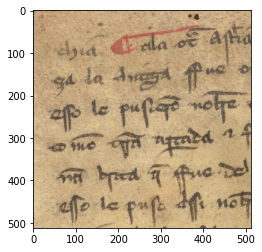

In [14]:
plt.imshow(original)

### JPEG compression

JPEG compression is developed for natural scenes. This means that even at 100% quality, we likely save some space. This family of compression falls under *lossy compression* since what we get out can e an image that doesn't look exactly like the original.

In [15]:
def compress(quality):
  result, compressed_image = cv2.imencode('.jpg', original, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
  decompressed_image = cv2.imdecode(compressed_image, 1)
  plt.figure(figsize=(7, 7))
  plt.imshow(decompressed_image)
  plt.show()
  print("Compression ratio %.1f" % (decompressed_image.nbytes/compressed_image.nbytes))
  print("Space saving %.1f%%" % (100*(1-compressed_image.nbytes/decompressed_image.nbytes)))

widgets.interact(compress, quality=widgets.IntSlider(min=1, max=100, step=1, value=100));

interactive(children=(IntSlider(value=100, description='quality', min=1), Output()), _dom_classes=('widget-int…

### Loss due to resizing

In [16]:
def resize(scale):
  new_dimensions = (int(original.shape[1]*scale/100),
                    int(original.shape[0]*scale/100))
  original_dimensions = (original.shape[1], original.shape[0])
  downscaled_image = cv2.resize(original, new_dimensions, interpolation=cv2.INTER_LANCZOS4)
  upscaled_image = cv2.resize(downscaled_image, original_dimensions, interpolation=cv2.INTER_LANCZOS4)
  plt.figure(figsize=(7, 7))
  plt.imshow(upscaled_image)
  plt.show()

widgets.interact(resize, scale=widgets.IntSlider(min=1, max=100, step=1, value=100));

interactive(children=(IntSlider(value=100, description='scale', min=1), Output()), _dom_classes=('widget-inter…

### PCA based compression

I write this as an example of what can happen if your compression doesn't take the nature of the image data into account. The original data is recreated with the data variance in mind, not necessarily for getting good colour reproduction.

In [17]:
patch_side = 32

patch_vectors = np.zeros(((512//patch_side)*(512//patch_side), patch_side*patch_side*3), dtype=original.dtype)
n = 0
for i in range(0, 512, patch_side):
  for j in range(0, 512, patch_side):
    patch_vectors[n, :] = original[i:i+patch_side, j:j+patch_side, :].ravel()
    n += 1
model = PCA()
transformed_patch_vectors = model.fit_transform(patch_vectors)
transformed_patch_vectors[:, 200:] = 0
new_patch_vectors = model.inverse_transform(transformed_patch_vectors)


def reconstruct(n_components):
  data = transformed_patch_vectors.copy()
  data[:, n_components:] = 0
  new_patch_vectors = model.inverse_transform(data)
  reconstruction = np.zeros(original.shape,  dtype=original.dtype)
  n = 0
  for i in range(0, 512, patch_side):
    for j in range(0, 512, patch_side):
      reconstruction[i:i+patch_side, j:j+patch_side, :] = new_patch_vectors[n, :].reshape((patch_side, patch_side, 3))
      n += 1
  plt.figure(figsize=(7, 7))
  plt.imshow(reconstruction, cmap='gray')
  plt.show()
  compressed_bytes = data[:, :n_components].nbytes + model.components_[:, :n_components].nbytes + model.mean_[:n_components].nbytes
  print("Compression ratio %.1f" % (original.nbytes/compressed_bytes))
  print("Space saving %.1f%%" % (100*(1-compressed_bytes/original.nbytes)))
  print("Explained variance %.1f%%" % (100*np.sum(model.explained_variance_ratio_[:n_components])))

widgets.interact(reconstruct, n_components=widgets.IntSlider(min=1, max=200, step=1, value=200));

interactive(children=(IntSlider(value=200, description='n_components', max=200, min=1), Output()), _dom_classe…